
# Learning with ensembles
</html>The goal behind ensemble methods is to combine different classifiers into a meta-classifier that has a better generalization performance than each individual classifier alone.
</html>

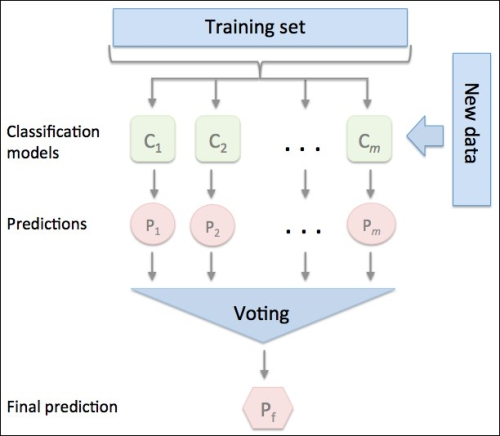

In [1]:
from IPython.display import Image
Image("/Users/surthi/gitrepos/ml-notes/images/ensemble.jpg")

# Popular Voting Principles

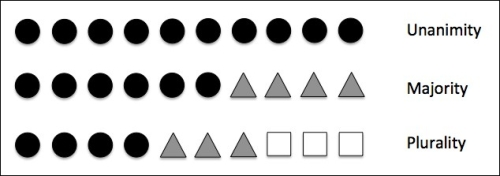

In [2]:
Image("/Users/surthi/gitrepos/ml-notes/images/popular-ensemble-methods.jpg")

# Does ensemble approach always perform better  than individual classifiers?

For this, let's take a simplistic case with following assumptions:
- All n base classifiers for a binary classification task have an equal error rate Learning with ensembles.
- Furthermore, we assume that the classifiers are independent
- The error rates are not correlated. 

Note that, in this simplified illustration, a 50-50 split by an even number of classifiers n is treated as an error. Under those assumptions, we can simply express the error probability of an ensemble of base classifiers as following probability mass function of a binomial distribution:

# Error probablity of ensemble:

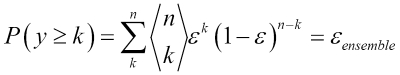

In [3]:
Image("/Users/surthi/gitrepos/ml-notes/images/ensemble-error.jpg")

# Implement Ensemble ErrorProbability and Plot its graph against base classifiers error rate:
To compare such an idealistic ensemble classifier to a base classifier over a range of different base error rates, let's implement above specified probability mass function(ensemble_error) in Python:

Error rate of an ensemble of 11 classifiers with 0.25 error rate = 0.034


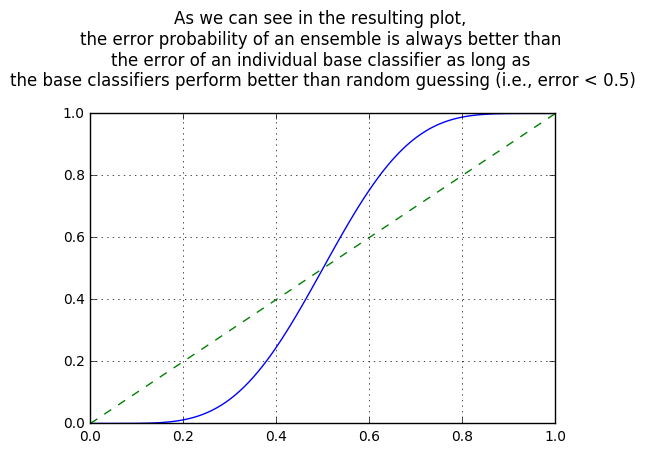

In [4]:
from scipy.misc import comb
import math

# 1. Implement Ensemble probability error rate
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier/2.0))
    t = [comb(n_classifier, k)*(error**k)*(1-error)**(n_classifier-k) 
         for k in range(k_start, n_classifier + 1)]
    return sum(t)

# 2. calculate error probability of ensemble if all 11 classifiers have error rate of 0.25
print("Error rate of an ensemble of 11 classifiers with 0.25 error rate = %.3f" %(ensemble_error(n_classifier=11, error=0.25)))

# 3. plot ensemble error probability against base classifier's error_rates
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ensemble_errors = [ensemble_error(11, e) for e in error_range]
plt.plot(error_range, ensemble_errors, label="Ensemble Error")
plt.plot(error_range, error_range, linestyle="--", label="Classifier Error")
plt.grid()
plt.title("As we can see in the resulting plot, \nthe error probability of an ensemble is always better than \nthe error of an individual base classifier as long as \nthe base classifiers perform better than random guessing (i.e., error < 0.5)\n")
plt.show()

In [5]:
# To compute weighted majority vote: 
print "To compute weighted majority vote: ", np.argmax(np.bincount([0,0,2,3,5,5,5]))

input = [[0.9,0.1],[0.8,0.2], [0.4,0.6]]
print "weighted majority vote: ", np.average(input, axis=0, weights=[0.2,0.2, 0.6])

To compute weighted majority vote:  5
weighted majority vote:  [ 0.58  0.42]


# Implement MajorityVoteClassifier

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        
        # Use LabelEncoder to ensure class labels start with 0.
        # This is important for np.argmax() call in self.predict
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        
        # fit with each classifier
        for clf in self.classifiers:
            clf.fit(X, self.labelenc_.transform(y))
        return self
    
    def predict(self, X):
        
        if self.vote == 'probability':
            np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers]).T
#            maj_vote = np.argmax(np.bincount(predictions, weights = self.weights), axis=1)
            maj_vote = np.apply_along_axis(
                           lambda x:
                           np.argmax(np.bincount(x,                                             
                                        weights=self.weights)),
                           axis=1,
                           arr=predictions)
            maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
        return out

# Combine and Compare different classification algorithms with majority vote
Using the training dataset, we now will train three different classifiers—a logistic regression classifier, a decision tree classifier, and a k-nearest neighbors classifier—and look at their individual performances via a 10-fold cross-validation on the training dataset before we combine them into an ensemble classifier

In [15]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np

# Load iris data
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# define classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

all_clf = [pipe1, clf2, pipe3, mv_clf]
cls_labels = ['LogisticRegression', 'DecisionTree', 'KNeighbours', 'Majority Voting']

# train clf's with kfold and print ROC score
for clf, label in zip(all_clf, cls_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print "ROC-AUC score: %.2f +/- %.2f [%s] " %(scores.mean(), scores.std(), label)

ROC-AUC score: 0.92 +/- 0.20 [LogisticRegression] 
ROC-AUC score: 0.92 +/- 0.15 [DecisionTree] 
ROC-AUC score: 0.93 +/- 0.10 [KNeighbours] 
ROC-AUC score: 0.97 +/- 0.10 [Majority Voting] 


# Plot FPR against TPR for MajorityVote and the individual classifiers its using

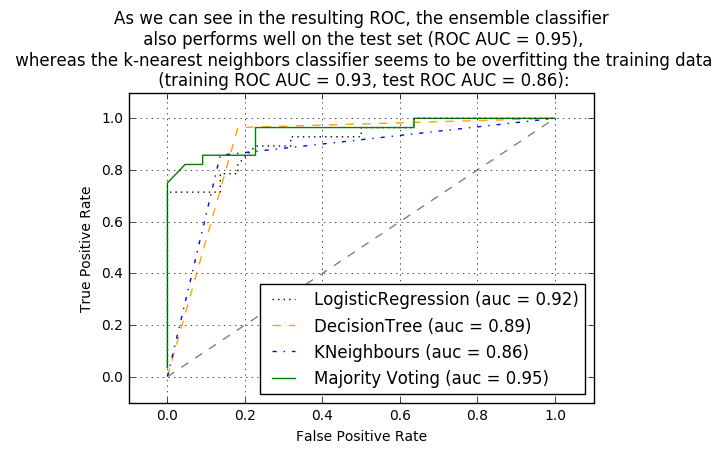

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, color, linestyle in zip(all_clf, cls_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=color, linestyle=linestyle, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0,1], [0,1],  linestyle='--', color='gray')
plt.title('As we can see in the resulting ROC, the ensemble classifier\n also performs well on the test set (ROC AUC = 0.95),\n whereas the k-nearest neighbors classifier seems to be overfitting the training data\n (training ROC AUC = 0.93, test ROC AUC = 0.86):')
plt.show()

# Plot decision regions of MajorityVote along with its individual classifiers

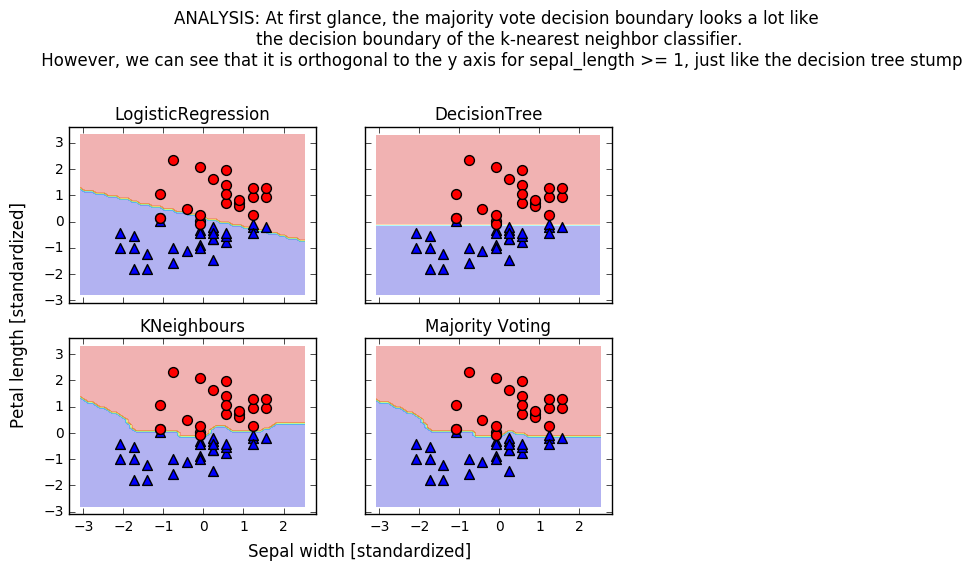

In [9]:
from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
b = np.c_[xx.ravel(), yy.ravel()]

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))
a = np.asarray([ [x,y] for y in np.arange(y_min, y_max, 0.1) for x in np.arange(x_min, x_max, 0.1)])
# print np.array_equal(a, b)

for idx, clf, tt in zip(product([0,1], [0,1]), all_clf, cls_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(a)
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)  
    axarr[idx[0], idx[1]].set_title(tt)
#     axarr[idx[0], idx[1]].set_xlim([-3,3])
#     axarr[idx[0], idx[1]].set_ylim([-3,3])
    
plt.text(+0, +15.0, ha='center', va='center', fontsize=12, s='ANALYSIS: At first glance, the majority vote decision boundary looks a lot like \nthe decision boundary of the k-nearest neighbor classifier.\n However, we can see that it is orthogonal to the y axis for sepal_length >= 1, just like the decision tree stump')
plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.0, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)
# plt.xlim([-3, 3])
# plt.ylim([-3, 3])
plt.show()

#print list(product([0, 1], [0, 1]))

# Tuning parametes of classifiers used in majority voting
# Let's first try and print params to get an idea of how to access them:

In [10]:
print mv_clf.get_params()

{'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_leaf_nodes': None, 'pipeline-2__clf__n_neighbors': 1, 'pipeline-1__clf__dual': False, 'pipeline-1__clf__solver': 'liblinear', 'pipeline-1__clf__C': 0.001, 'pipeline-1__clf__fit_intercept': True, 'decisiontreeclassifier__random_state': 0, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__min_impurity_split': 1e-07, 'pipeline-1__clf__n_jobs': 1, 'pipeline-1__sc__with_std': True, 'pipeline-1__sc__copy': True, 'pipeline-1__sc__with_mean': True, 'decisiontreeclassifier__presort': False, 'decisiontreeclassifier__min_samples_split': 2, 'pipeline-2__clf__p': 2, 'pipeline-2__clf__metric_params': None, 'pipeline-1__clf__penalty': 'l2', 'pipeline-2__clf__leaf_size': 30, 'pipeline-1__clf': LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penal

# Use grid search to tune:
<html>
<ul>
<li> the inverse regularization parameter C of the logistic regression classifier and </li>
<li> the decision tree depth via a grid search </li>
</ul>
</html>

In [14]:
from sklearn.grid_search import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for params, mean_score, scores in grid.grid_scores_:
    print " ROC AUC: %.3f+/-%.3f [%r]" %(mean_score, scores.std()/2, params)

 ROC AUC: 0.967+/-0.050 [{'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}]
 ROC AUC: 0.967+/-0.050 [{'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}]
 ROC AUC: 1.000+/-0.000 [{'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}]
 ROC AUC: 0.967+/-0.050 [{'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}]
 ROC AUC: 0.967+/-0.050 [{'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}]
 ROC AUC: 1.000+/-0.000 [{'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}]
